# Semiconductor Manufacturing - Test Result Classification Project

## Model Evaluation

This notebook contains model performance evaluation, compare with baseline model (assume all minority) using F_1.5. 

- Evaluation metrics: F1.5
  

In [115]:
# data wrangling
import numpy as np 
import pandas as pd 

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, recall_score, roc_auc_score, accuracy_score,fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# models
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.linear_model import LogisticRegression, Lasso
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, f1_score, accuracy_score, recall_score, precision_score

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# real and load model development results
from sklearn.dummy import DummyClassifier
import joblib
import shap

#### Data prep

In [130]:
# Data preparation, same as model dev
data = pd.read_csv('../data/uci-secom.csv')

unique_value_columns = data.columns[data.nunique() == 1]
data_cleaned = data.drop(columns=unique_value_columns) 

# 2. Drop the features have correlation with other feaures more than 0.9
corr_matrix = data_cleaned.iloc[:, 1:].corr()
strong_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            strong_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Drop features with strong correlation (|corr| > 0.9)
features_to_drop = set()
for feature1, feature2, corr_value in strong_corr_pairs:
    if abs(corr_value) > 0.9:
        features_to_drop.add(feature2)

data_cleaned = data_cleaned.drop(columns=features_to_drop)
print("New data shape after dropping strongly correlated features:", data_cleaned.shape)

df_na_0 = data_cleaned.replace(np.NaN, 0) 
df_na = data_cleaned 

y = data_cleaned['Pass/Fail']
y = np.where(y == -1, 0, 1) # map -1 to 0, so 0 is pass and 1 is fail
X_0 = df_na_0.drop(columns=['Pass/Fail','Time'])
X_XGB = df_na.drop(columns=['Pass/Fail','Time']) 

New data shape after dropping strongly correlated features: (1567, 256)


#### Baseline F1.5 Score

- Use whole dataset
- Assume all as minority group, where y = 1
- Baseline F1.5 socre: 0.1877

In [117]:
# baseline score with round to 4 decimal
y_baseline =  np.ones_like(y) # predict all as minority class
baseline_f_1_5 = round(fbeta_score(y, y_baseline, beta=1.5),4)
print(f'Baseline f1.5 score: {baseline_f_1_5}')

Baseline f1.5 score: 0.1877


In [118]:
scorers = {
    'f0.5':make_scorer(fbeta_score, beta=0.5, pos_label=1),
    'f1':make_scorer(f1_score, pos_label=1),
    'f1.5':make_scorer(fbeta_score, beta=1.5, pos_label=1)
    # 'f1_micro':make_scorer(f1_score, average='micro'),
    # 'recall':make_scorer(recall_score, pos_label=1),
    #'precision':make_scorer(precision_score, pos_label=1)
    }

baseline_result = {}

for key, scorer in scorers.items():
    baseline_result[key] = round(scorer._score_func(y, y_baseline, **scorer._kwargs),4)

print("baseline results for different evaluation metrics:\n", baseline_result)

baseline results for different evaluation metrics:
 {'f0.5': 0.0816, 'f1': 0.1245, 'f1.5': 0.1877}


In [119]:
def model_eval_scores(X, y, result, scorers):
    random_state = result['random_state']
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
    result['scores'] = {}
    for key,scorer in scorers.items():
        result['scores'][key] = scorer._score_func(y_test, result['y_test_pred'], **scorer._kwargs )
        
    return result


In [120]:
def model_eval_scores(X, y, result, scorers):
    result['scores'] = {}
    for key,scorer in scorers.items():
        result['scores'][key] = scorer._score_func(result['y_test'], result['y_test_pred'], **scorer._kwargs )   
    return result


### Add evlaluation result to each model

In [121]:
lr_results = joblib.load('../results/lr_results.pkl')
for result in lr_results:
    result = model_eval_scores(X_0, y, result, scorers)

svc_results = joblib.load('../results/svc_results.pkl')
for result in svc_results:
    result = model_eval_scores(X_0, y, result, scorers)

rf_results = joblib.load('../results/rf_results.pkl')
for result in rf_results:
    result = model_eval_scores(X_0, y, result, scorers)

xgb_results = joblib.load('../results/xgb_results.pkl')
for result in xgb_results:
    result = model_eval_scores(X_XGB, y, result, scorers)

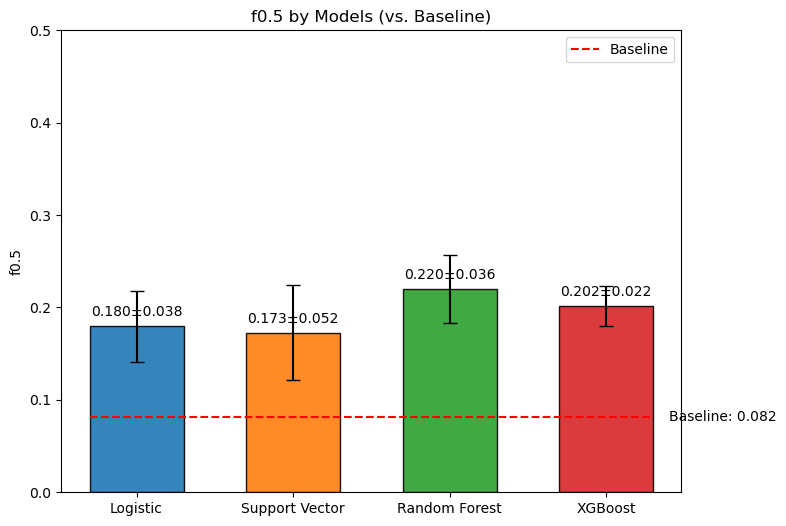

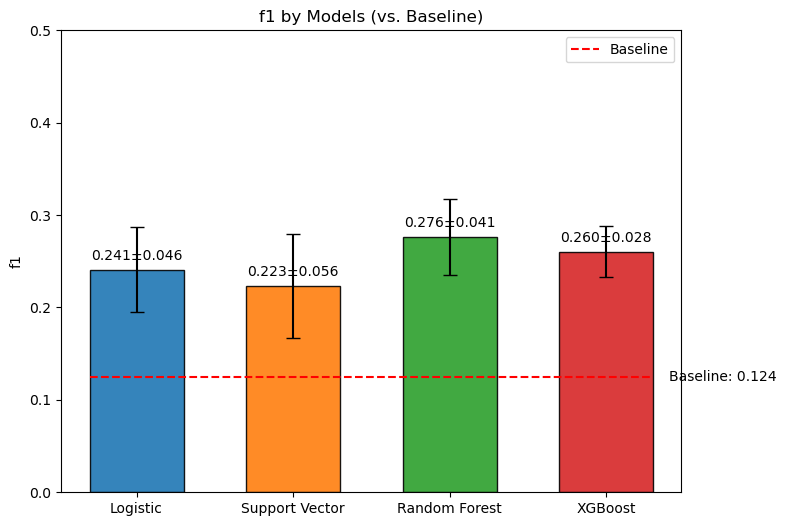

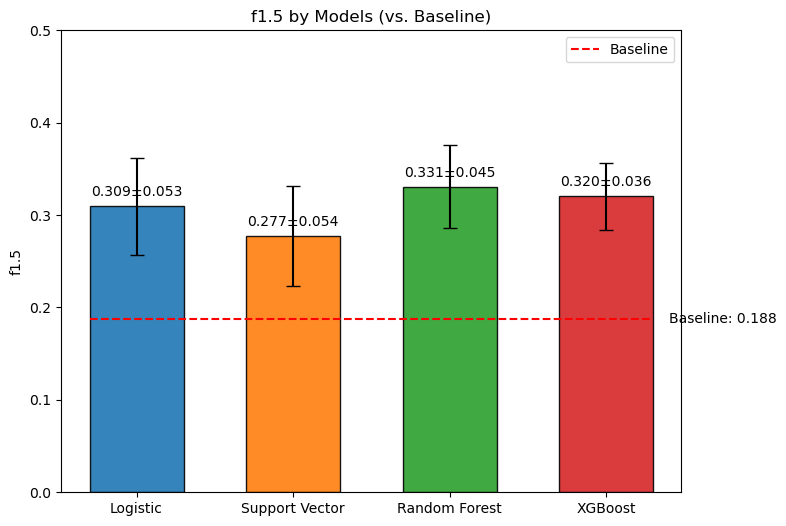

In [122]:
import os
random_states = range(5)

# Model labels
labels = ['Logistic', 'Support Vector', 'Random Forest', 'XGBoost']

# Helper function to get mean & std for a given metric across runs for a model
def get_mean_std(results, metric):
    vals = [res['scores'][metric] for res in results]
    return np.mean(vals), np.std(vals)

# Loop over each metric and create a bar plot
for metric in scorers.keys():
    # Compute means and stds for each model
    lr_mean, lr_std = get_mean_std(lr_results, metric)
    svc_mean, svc_std = get_mean_std(svc_results, metric)
    rf_mean, rf_std = get_mean_std(rf_results, metric)
    xgb_mean, xgb_std = get_mean_std(xgb_results, metric)

    # baseline socre
    baseline_score = baseline_result[metric]

    # Bar plot
    means = [lr_mean, svc_mean, rf_mean, xgb_mean]
    stds = [lr_std, svc_std, rf_std, xgb_std]

    x = np.arange(len(labels))
    width = 0.6

    fig, ax = plt.subplots(figsize=(8,6))
    rects = ax.bar(x, means, width, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], 
                   edgecolor='black', alpha=0.9, yerr=stds, capsize=5)

    # Baseline line
    ax.hlines(y=baseline_score, xmin=x[0]-width/2, xmax=x[-1]+width/2, color='r', linestyles='dashed', label='Baseline')

    ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Models (vs. Baseline)')
    ax.set_xticks(x, labels)
    ax.set_ylim(0, 0.5) 
    ax.legend()


    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{means[i]:.3f}±{stds[i]:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 5),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    # Annotate baseline line
    ax.text(x[-1]+width/1.5, baseline_score, f'Baseline: {baseline_score:.3f}', 
            va='center', ha='left', fontsize=10)


    file_name = f'model_comparison_{metric}.png'
    plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

    plt.show()

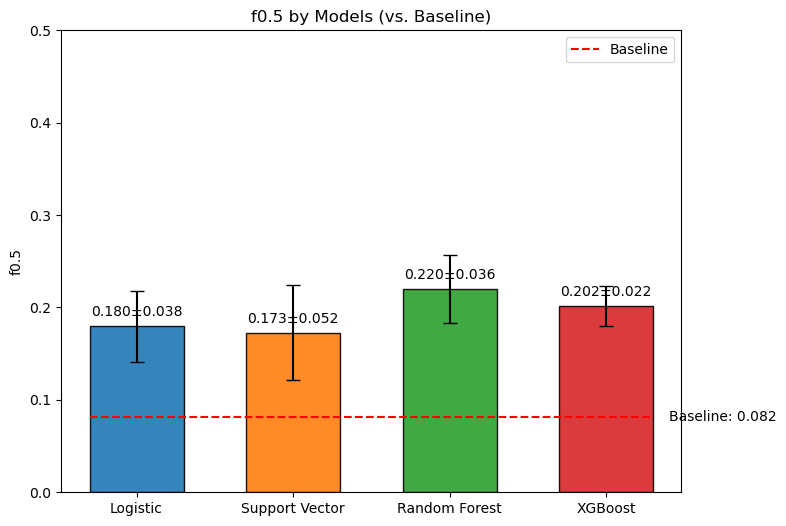

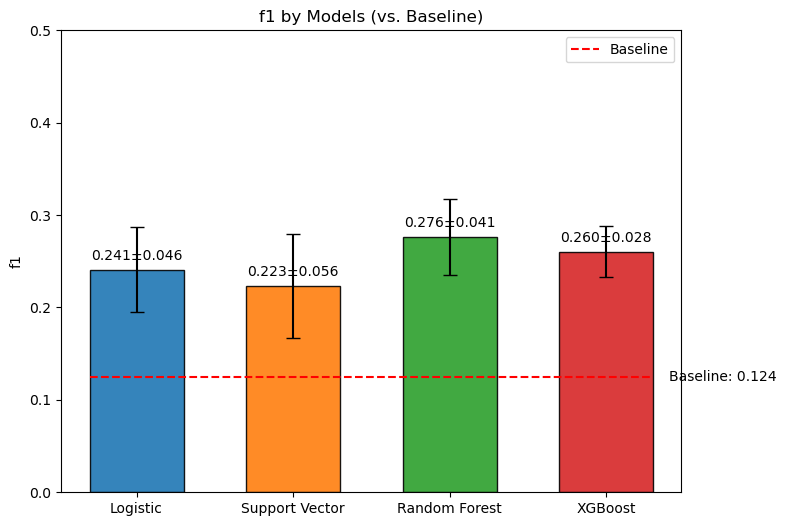

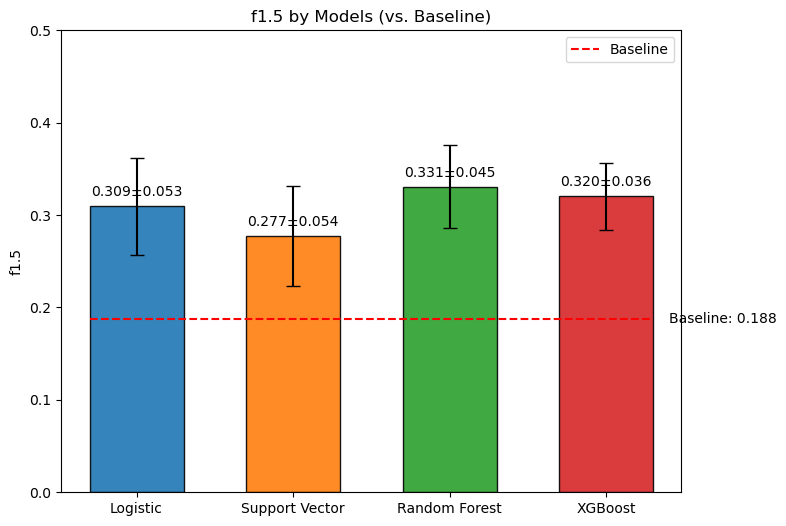

In [57]:
import os
random_states = range(5)

# Model labels
labels = ['Logistic', 'Support Vector', 'Random Forest', 'XGBoost']

# Helper function to get mean & std for a given metric across runs for a model
def get_mean_std(results, metric):
    vals = [res['scores'][metric] for res in results]
    return np.mean(vals), np.std(vals)

# Loop over each metric and create a bar plot
for metric in scorers.keys():
    # Compute means and stds for each model
    lr_mean, lr_std = get_mean_std(lr_results, metric)
    svc_mean, svc_std = get_mean_std(svc_results, metric)
    rf_mean, rf_std = get_mean_std(rf_results, metric)
    xgb_mean, xgb_std = get_mean_std(xgb_results, metric)

    # baseline socre
    baseline_score = baseline_result[metric]

    # Bar plot
    means = [lr_mean, svc_mean, rf_mean, xgb_mean]
    stds = [lr_std, svc_std, rf_std, xgb_std]

    x = np.arange(len(labels))
    width = 0.6

    fig, ax = plt.subplots(figsize=(8,6))
    rects = ax.bar(x, means, width, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], 
                   edgecolor='black', alpha=0.9, yerr=stds, capsize=5)

    # Baseline line
    ax.hlines(y=baseline_score, xmin=x[0]-width/2, xmax=x[-1]+width/2, color='r', linestyles='dashed', label='Baseline')

    ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Models (vs. Baseline)')
    ax.set_xticks(x, labels)
    ax.set_ylim(0, 0.5) 
    ax.legend()


    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{means[i]:.3f}±{stds[i]:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 5),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    # Annotate baseline line
    ax.text(x[-1]+width/1.5, baseline_score, f'Baseline: {baseline_score:.3f}', 
            va='center', ha='left', fontsize=10)


    # file_name = f'model_comparison_{metric}.png'
    # plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

    plt.show()

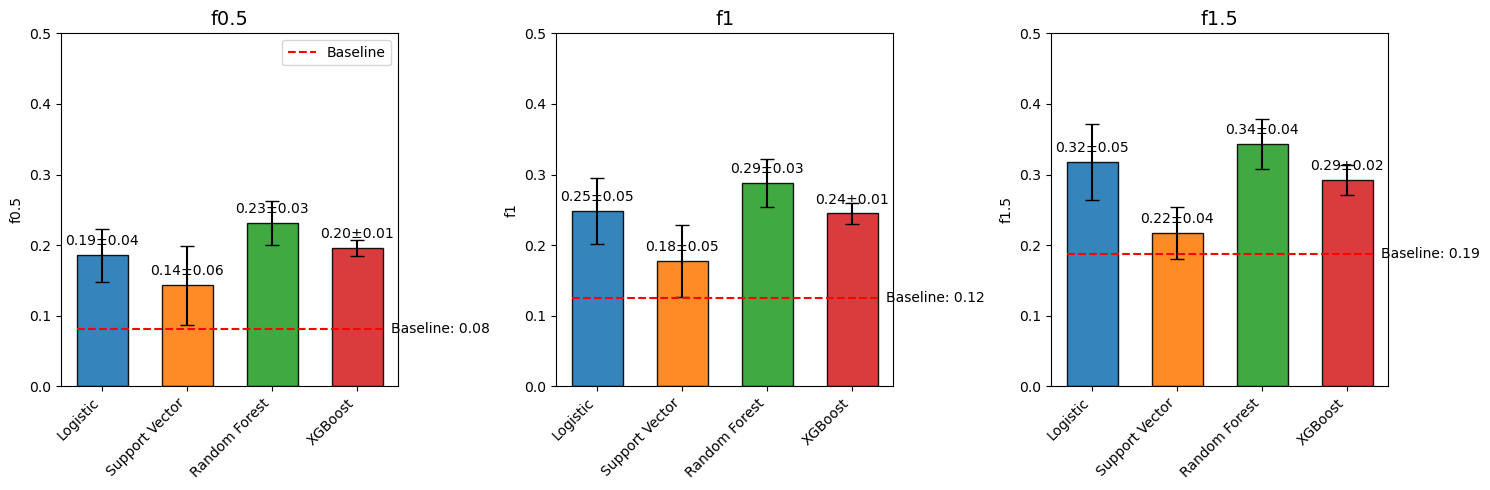

In [45]:
# Metric-specific y-limits
metric_ylims = {
    'f1_micro': (0, 1.0)
}
# Default ylim if not specified above
default_ylim = (0, 0.5)

# Prepare to plot all metrics in a single figure
all_metrics = list(scorers.keys())
n_metrics = len(all_metrics)


rows = 1
cols = 3

fig, axes = plt.subplots(rows, cols,figsize=(15, 5))
axes = axes.flatten()  # Flatten to iterate easily

for i, metric in enumerate(all_metrics):
    ax = axes[i]

    # Compute means and stds for each model
    lr_mean, lr_std = get_mean_std(lr_results, metric)
    svc_mean, svc_std = get_mean_std(svc_results, metric)
    rf_mean, rf_std = get_mean_std(rf_results, metric)
    xgb_mean, xgb_std = get_mean_std(xgb_results, metric)


    means = [lr_mean, svc_mean, rf_mean, xgb_mean]
    stds = [lr_std, svc_std, rf_std, xgb_std]

    x = np.arange(len(labels))
    width = 0.6

    rects = ax.bar(x, means, width, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'],
                   edgecolor='black', alpha=0.9, yerr=stds, capsize=5)

    # Baseline line
    baseline_score = baseline_result[metric]
    ax.hlines(y=baseline_score, xmin=x[0]-width/2, xmax=x[-1]+width/2, color='r', linestyles='dashed', label='Baseline')

    # Y-limits based on metric
    if metric in metric_ylims:
        ax.set_ylim(metric_ylims[metric])
    else:
        ax.set_ylim(default_ylim)

    # Title and labels
    ax.set_title(metric, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(metric)

    # Annotate bars with mean±std
    for j, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{means[j]:.2f}±{stds[j]:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    
    # Annotate baseline line to the right
    ax.text(x[-1]+width/1.5, baseline_score, f'Baseline: {baseline_score:.2f}', 
            va='center', ha='left', fontsize=10)

# Add a legend for baseline in one of the subplots
axes[0].legend()

plt.tight_layout()
file_name = 'model_comparison_all_metrics.png'
plt.savefig(os.path.join('../figures', file_name), dpi=500, bbox_inches="tight")
plt.show()

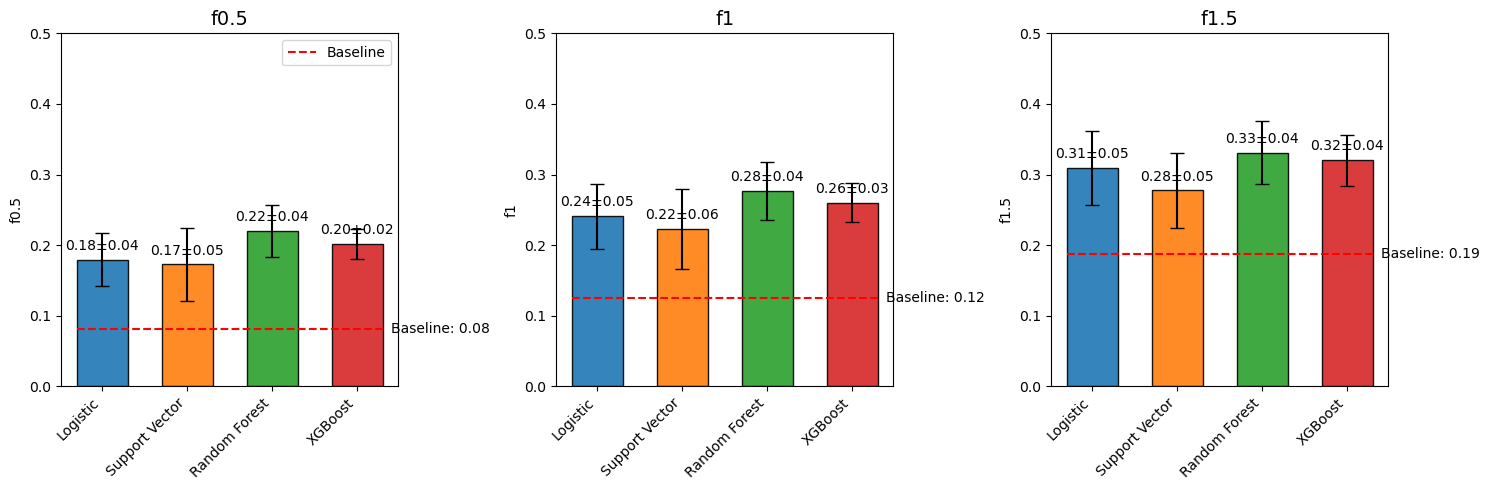

In [58]:
# Metric-specific y-limits
metric_ylims = {
    'f1_micro': (0, 1.0)
}
# Default ylim if not specified above
default_ylim = (0, 0.5)

# Prepare to plot all metrics in a single figure
all_metrics = list(scorers.keys())
n_metrics = len(all_metrics)


rows = 1
cols = 3

fig, axes = plt.subplots(rows, cols,figsize=(15, 5))
axes = axes.flatten()  # Flatten to iterate easily

for i, metric in enumerate(all_metrics):
    ax = axes[i]

    # Compute means and stds for each model
    lr_mean, lr_std = get_mean_std(lr_results, metric)
    svc_mean, svc_std = get_mean_std(svc_results, metric)
    rf_mean, rf_std = get_mean_std(rf_results, metric)
    xgb_mean, xgb_std = get_mean_std(xgb_results, metric)


    means = [lr_mean, svc_mean, rf_mean, xgb_mean]
    stds = [lr_std, svc_std, rf_std, xgb_std]

    x = np.arange(len(labels))
    width = 0.6

    rects = ax.bar(x, means, width, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'],
                   edgecolor='black', alpha=0.9, yerr=stds, capsize=5)

    # Baseline line
    baseline_score = baseline_result[metric]
    ax.hlines(y=baseline_score, xmin=x[0]-width/2, xmax=x[-1]+width/2, color='r', linestyles='dashed', label='Baseline')

    # Y-limits based on metric
    if metric in metric_ylims:
        ax.set_ylim(metric_ylims[metric])
    else:
        ax.set_ylim(default_ylim)

    # Title and labels
    ax.set_title(metric, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(metric)

    # Annotate bars with mean±std
    for j, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{means[j]:.2f}±{stds[j]:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    
    # Annotate baseline line to the right
    ax.text(x[-1]+width/1.5, baseline_score, f'Baseline: {baseline_score:.2f}', 
            va='center', ha='left', fontsize=10)

# Add a legend for baseline in one of the subplots
axes[0].legend()

plt.tight_layout()
# file_name = 'model_comparison_all_metrics.png'
# plt.savefig(os.path.join('../figures', file_name), dpi=500, bbox_inches="tight")
plt.show()

### Model Inspection

#### Confusion Matrix for Bset Model of each ML Algo

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def find_best_model(model_results):

    mean_f1_5 = np.mean([result['scores']['f1.5'] for result in model_results])
    absf1_5_diff = np.abs(np.array([result['scores']['f1.5'] for result in model_results]) - mean_f1_5)
    repr_idx = np.argmin(absf1_5_diff)
    reference_result = model_results[repr_idx]
    # reference_random_state = reference_result['random_state']
    grid = reference_result['grid'] 

    y_test_pred = reference_result['y_test_pred']
    y_test = reference_result['y_test']

    return grid, y_test, y_test_pred

def plot_confusion_matrix(ML_name,y_test, y_test_pred):
    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Pass', 'Fail'], # normalize='true',
                                                 cmap='GnBu_r', im_kw={'alpha':0.95})
    cm.ax_.set_title(f'{ML_name}: Best Model Confusion Matrix')
    file_name = f'{ML_name}_Bestmodel_Confurion_Matrix.png'
    plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

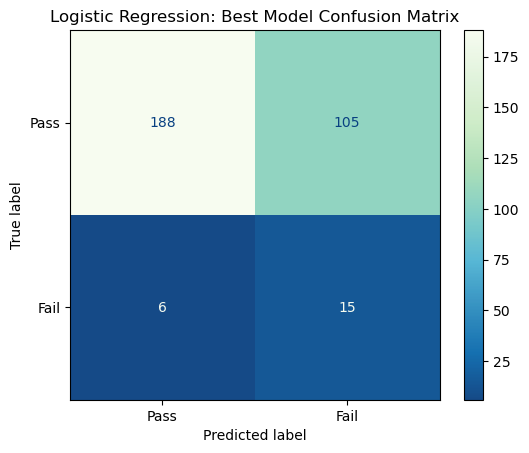

In [124]:
ly_grid, lr_y_test, lr_y_test_pred = find_best_model(lr_results)
plot_confusion_matrix('Logistic Regression',lr_y_test, lr_y_test_pred)

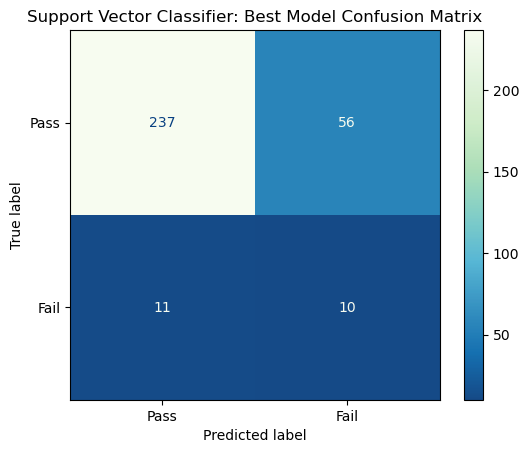

In [125]:
svc_grid, svc_test, svc_y_test_pred = find_best_model(svc_results)
plot_confusion_matrix('Support Vector Classifier',svc_test, svc_y_test_pred)

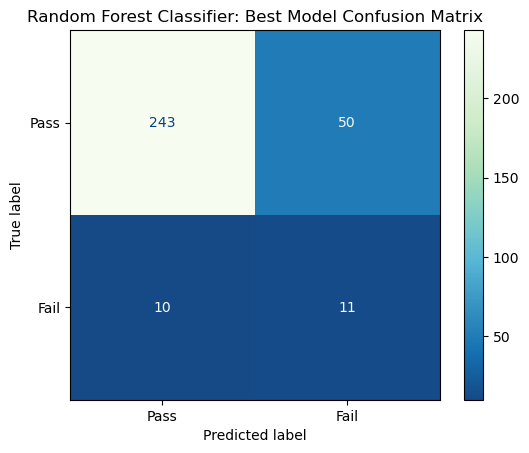

In [126]:
rf_grid, rf_test, rf_y_test_pred = find_best_model(rf_results)
plot_confusion_matrix('Random Forest Classifier',rf_test, rf_y_test_pred)

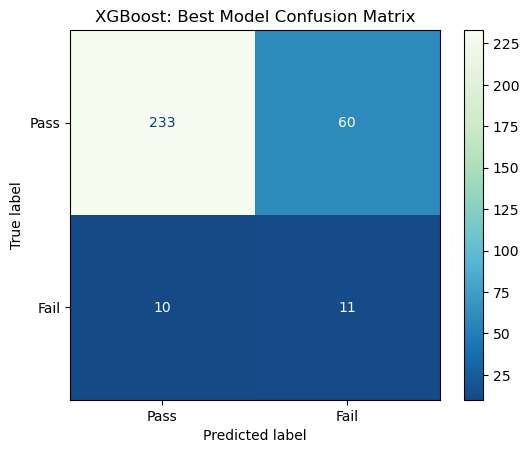

In [127]:
xgb_grid, xgb_test,xgb_y_test_pred = find_best_model(xgb_results)
plot_confusion_matrix('XGBoost',xgb_test,xgb_y_test_pred)

In [132]:
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import fbeta_score, make_scorer

X_other, X_test, y_other, y_test = train_test_split(X_0, y, test_size=0.2, stratify=y, random_state=1)

# Define the best rf pipeline
rf_pipe = make_pipeline(rf_grid.best_estimator_)

# Calculate permutation importance with F1.5 as the scoring metric
pi_result_rf = permutation_importance(
    rf_pipe, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=1, 
    scoring=make_scorer(fbeta_score, beta=1.5, pos_label=1)  # Use F1.5
)

# Extract top-10 features based on mean importance
importances_idx_rf = pi_result_rf.importances_mean.argsort()
top10_features_rf = np.array(X_test.columns)[importances_idx_rf][-10:]
top10_importances_rf = pi_result_rf.importances[importances_idx_rf][-10:]



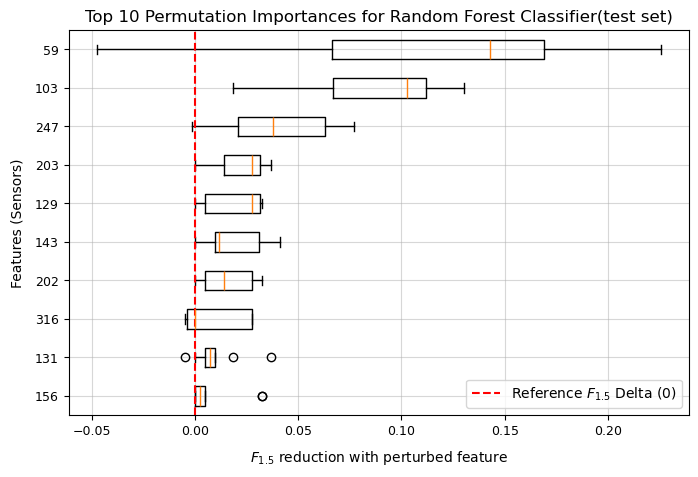

In [134]:
# Plot top-10 permutation feature importances
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(x=top10_importances_rf.tolist(), 
           labels=top10_features_rf.tolist(), 
           vert=False)

ax.axvline(0, label='Reference $F_{1.5}$ Delta (0)', linestyle='--', color='red')
ax.set_title('Top 10 Permutation Importances for Random Forest Classifier(test set)')
ax.set_xlabel('$F_{1.5}$ reduction with perturbed feature', fontsize=10, labelpad=8)
ax.set_ylabel('Features (Sensors)', fontsize=10, labelpad=8)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.grid(alpha=0.5)
ax.legend()
file_name = 'random-forest-top10-permutation-importance-f1.5.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
plt.show()

In [136]:
# Use SHAP for local feature importance
explainer = shap.Explainer(rf_pipe.predict, X_other, max_evals=1000)
shap_values = explainer(X_test)


PermutationExplainer explainer: 315it [00:39,  5.98it/s]                         


In [ ]:

# Plot local feature importance for a specific instance (e.g., instance 0)
instance_idx = 0  # Index of the instance to analyze
shap.plots.waterfall(shap_values[instance_idx], max_display=10)

# Save the plot
file_name = f'logistic-local-feature-importance-instance-{instance_idx}.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
plt.show()

# Optional: Summarize SHAP values for all instances
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)
file_name = 'logistic-summary-feature-importance.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Ensure the pipeline and SHAP explainer are correctly set up
logistic_pipe = make_pipeline(reference_result['grid'].best_estimator_)
logistic_pipe.fit(X_other, y_other)  # Fit the pipeline on the training data

# Use SHAP to calculate SHAP values for the test set
explainer = shap.Explainer(logistic_pipe.predict, X_other, max_evals=1000)
shap_values = explainer(X_test)


PermutationExplainer explainer: 315it [01:19,  3.45it/s]                         


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [135]:
# If feature names are not explicitly available, infer from X_test
feature_names = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'Feature {i}' for i in range(X_test.shape[1])]

# Calculate the mean(|SHAP values|) summary for binary prediction
shap_summary = np.mean(np.abs(shap_values.values), axis=0)
indcs = np.argsort(shap_summary)  # Indices of features sorted by importance
sorted_shap_summary = shap_summary[indcs]

# Plot the top 10 features
top_features = np.array(feature_names)[indcs[-10:]]  # Use inferred feature names
top_shap_summary = sorted_shap_summary[-10:]

plt.figure(figsize=(8, 6))
plt.barh(top_features, top_shap_summary)
plt.xlabel('mean(|SHAP value|)')
plt.title('Top 10 Features by SHAP Importance')
plt.tight_layout()

# Save the summary plot as a PNG file
# file_name = 'logistic-summary-feature-importance.png'
# plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

plt.show()

IndexError: index 409 is out of bounds for axis 0 with size 254

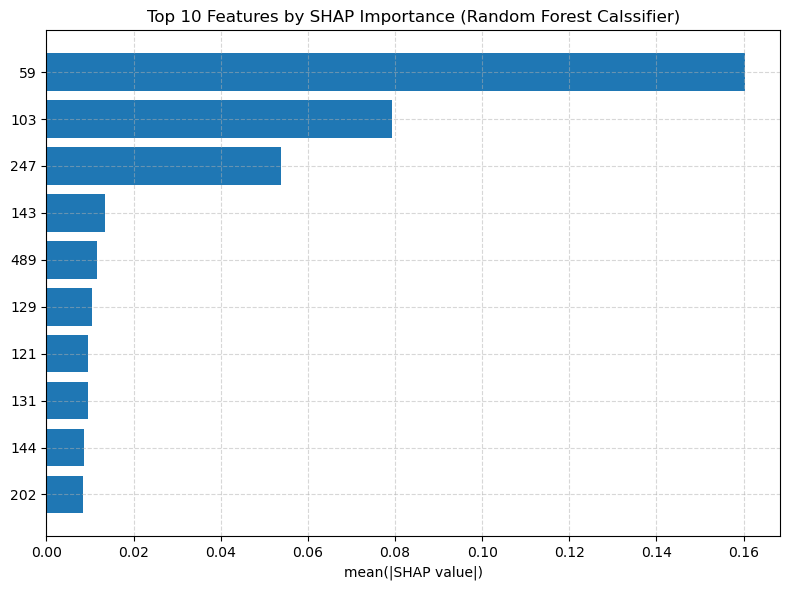

In [140]:
# If feature names are not explicitly available, infer from X_test
feature_names = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'Feature {i}' for i in range(X_test.shape[1])]

# Calculate the mean(|SHAP values|) summary for binary prediction
shap_summary = np.mean(np.abs(shap_values.values), axis=0)
indcs = np.argsort(shap_summary)  # Indices of features sorted by importance
sorted_shap_summary = shap_summary[indcs]

# Plot the top 10 features
top_features = np.array(feature_names)[indcs[-10:]]  # Use inferred feature names
top_shap_summary = sorted_shap_summary[-10:]

plt.figure(figsize=(8, 6))
plt.barh(top_features, top_shap_summary)
plt.xlabel('mean(|SHAP value|)')
plt.title('Top 10 Features by SHAP Importance (Random Forest Calssifier)')
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# Save the summary plot as a PNG file
file_name = 'rf-shap-global-feature-importance.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

plt.show()

In [ ]:

gain_scores = reference_xgb_booster.get_score(importance_type='gain')
weight_scores = reference_xgb_booster.get_score(importance_type='weight')
cover_scores = reference_xgb_booster.get_score(importance_type='cover')
total_gain_scores = reference_xgb_booster.get_score(importance_type='total_gain')
total_cover_scores = reference_xgb_booster.get_score(importance_type='total_cover')

# Normalize scores and create DataFrames
gain = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Gain'),
                  zip(gain_scores.keys(), gain_scores.values(),
                      [sum(gain_scores.values())]*len(gain_scores.values()))),
              key=lambda x: x[1], reverse=True)

weight = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Weight'),
                    zip(weight_scores.keys(), weight_scores.values(),
                        [sum(weight_scores.values())]*len(weight_scores.values()))),
                key=lambda x: x[1], reverse=True)

cover = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Cover'),
                   zip(cover_scores.keys(), cover_scores.values(),
                       [sum(cover_scores.values())]*len(cover_scores.values()))),
               key=lambda x: x[1], reverse=True)

total_gain = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Total Gain'),
                        zip(total_gain_scores.keys(), total_gain_scores.values(),
                            [sum(total_gain_scores.values())]*len(total_gain_scores.values()))),
                    key=lambda x: x[1], reverse=True)

total_cover = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Total Cover'),
                         zip(total_cover_scores.keys(), total_cover_scores.values(),
                             [sum(total_cover_scores.values())]*len(total_cover_scores.values()))),
                    key=lambda x: x[1], reverse=True)

# Create DataFrames for each importance type
gain_df = pd.DataFrame(gain, columns=['Feature', 'Score', 'Score Type'])
weight_df = pd.DataFrame(weight, columns=['Feature', 'Score', 'Score Type'])
cover_df = pd.DataFrame(cover, columns=['Feature', 'Score', 'Score Type'])
total_gain_df = pd.DataFrame(total_gain, columns=['Feature', 'Score', 'Score Type'])
total_cover_df = pd.DataFrame(total_cover, columns=['Feature', 'Score', 'Score Type'])

# Combine all DataFrames into a list for easier handling
scores_list = [gain_df, weight_df, cover_df, total_gain_df, total_cover_df]

# Plot top-10 features for each importance type
fig, ax = plt.subplots(len(scores_list), 1, figsize=(8, 20))
ax = ax.flatten()

for i, df in enumerate(scores_list):
    top10_df = df.head(10)  # Get top-10 features
    ax[i].barh(y=top10_df['Feature'][::-1], width=top10_df['Score'][::-1], height=0.5)
    ax[i].set_title(f"Top 10 Features by {top10_df['Score Type'].unique()[0]}", fontsize=10)
    ax[i].set_xlabel(top10_df['Score Type'].unique()[0], fontsize=9, labelpad=8)
    ax[i].set_ylabel('Feature', fontsize=9, labelpad=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8.5)
    ax[i].grid(alpha=0.25)

# Add a global title and adjust layout
fig.tight_layout(pad=2.5)
fig.suptitle('Comparison of Top Features by Different Importance Scores', 
             x=0.5, y=1.01, fontsize=12)

# Save the plot to a file
file_name = 'top10-xgb-importance.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
plt.show()


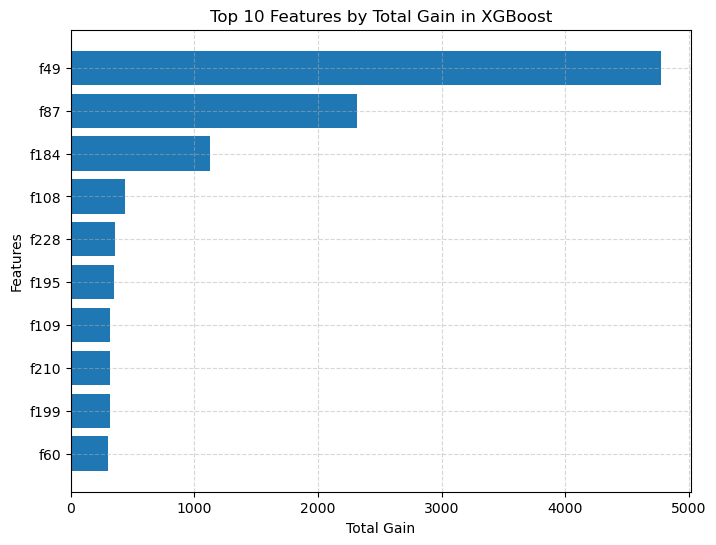

In [151]:
importances = xgb_grid.best_estimator_.named_steps['model'].get_booster().get_score(importance_type='total_gain')

sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 features
top_features = sorted_importances[:10]

# Unpack the feature names and their corresponding gains
features, gains = zip(*top_features)

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(features, gains)
plt.gca().invert_yaxis()  # Invert y-axis for a descending order display
plt.title('Top 10 Features by Total Gain in XGBoost')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('Total Gain')
plt.ylabel('Features')
file_name = 'xgb-total-gain-feature-importance.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
plt.show()

Generating SHAP plot for instance 85


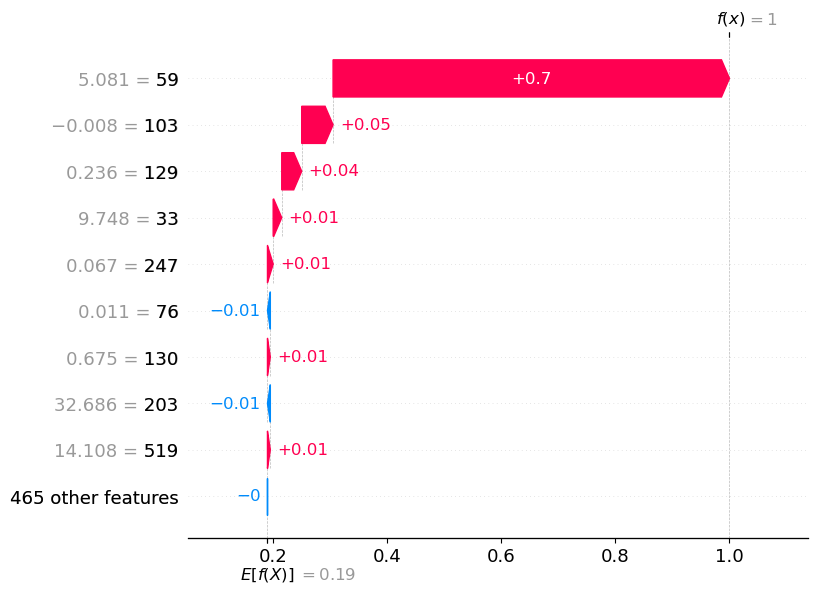

<Figure size 640x480 with 0 Axes>

Generating SHAP plot for instance 46


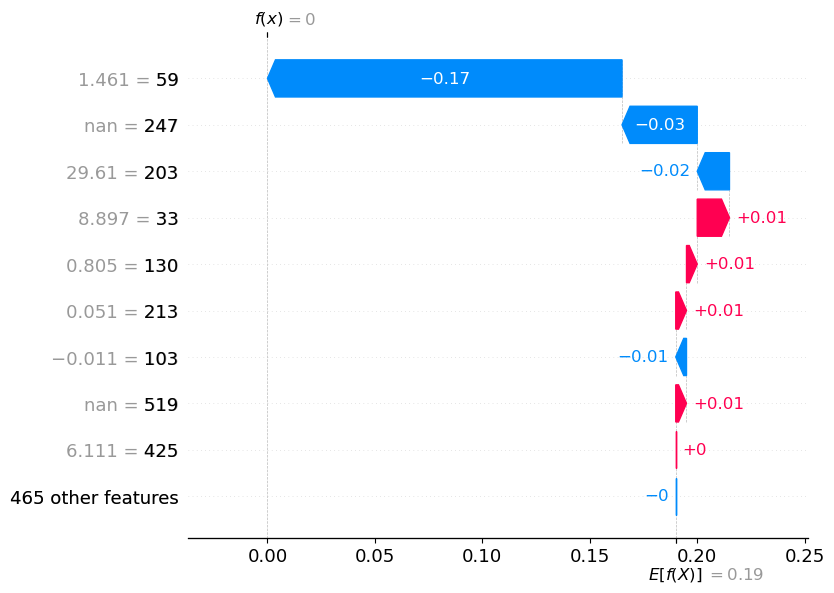

<Figure size 640x480 with 0 Axes>

Generating SHAP plot for instance 40


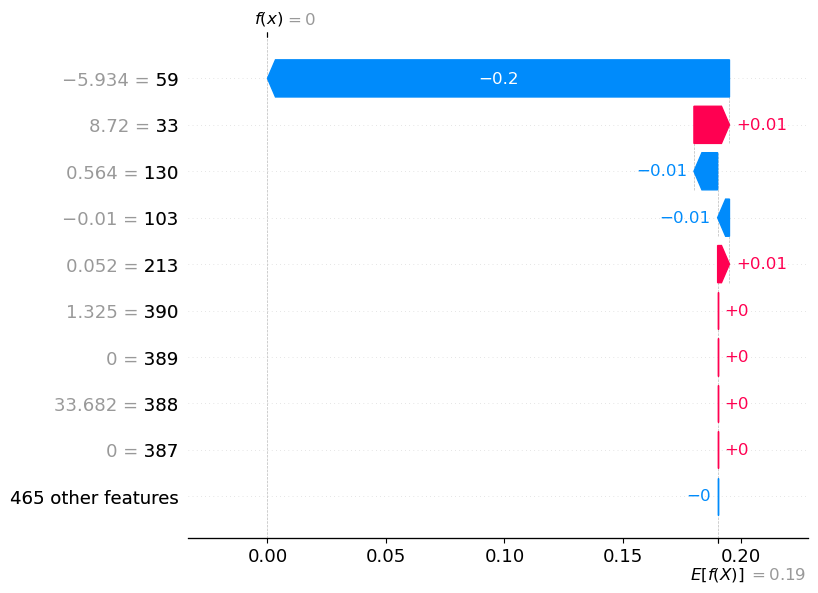

<Figure size 640x480 with 0 Axes>

Generating SHAP plot for instance 168


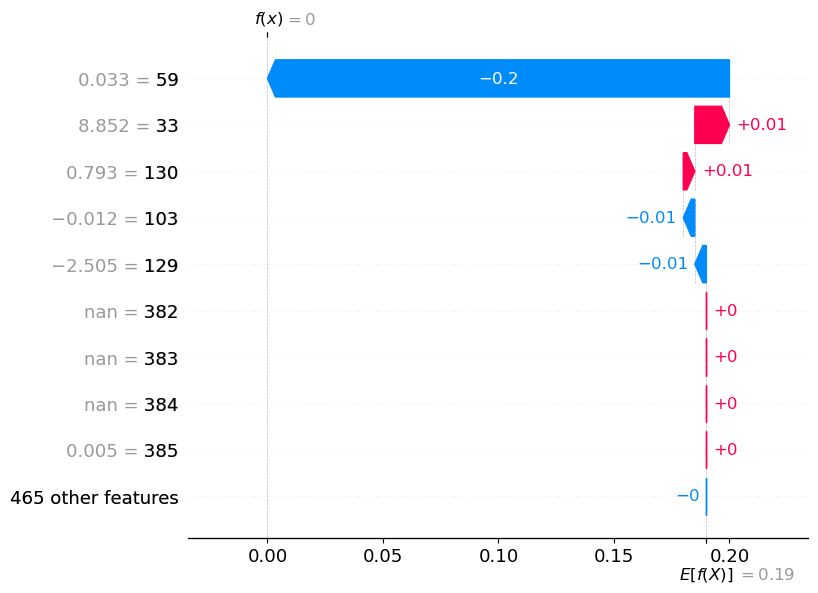

<Figure size 640x480 with 0 Axes>

Generating SHAP plot for instance 76


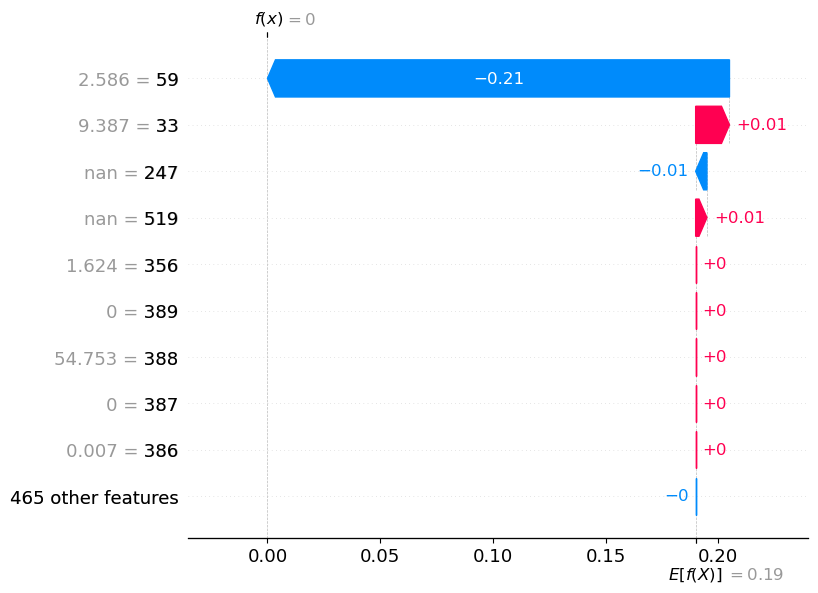

<Figure size 640x480 with 0 Axes>

In [122]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import random


# Randomly select data points for local analysis
num_points = 5  # Number of random points to select
random_indices = random.sample(range(X_test.shape[0]), num_points)

# Generate SHAP waterfall plots for selected points
for idx in random_indices:
    print(f"Generating SHAP plot for instance {idx}")
    shap.plots.waterfall(shap_values[idx], max_display=10)

    # Save the waterfall plot
    file_name = f'shap-local-analysis-instance-{idx}.png'
    plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
    plt.show()


In [118]:
import shap
import matplotlib.pyplot as plt
import os
# Ensure the pipeline and SHAP explainer are correctly set up
logistic_pipe = make_pipeline(reference_result['grid'].best_estimator_)
logistic_pipe.fit(X_other, y_other)  # Fit the pipeline on the training data

# Use SHAP to calculate SHAP values for the test set
explainer = shap.Explainer(logistic_pipe.predict, X_other, max_evals=1000)
shap_values = explainer(X_test)



PermutationExplainer explainer: 315it [02:02,  2.34it/s]                         


In [147]:
# Compute the expected value manually (mean prediction)
expected_value = rf_pipe.predict(X_other).mean()

#set random state as 42
np.random.seed(1)
# Randomly select points for SHAP local analysis
num_points = 5  # Number of points to analyze
random_indices = np.random.choice(range(X_test.shape[0]), num_points, replace=False)

# Generate and save SHAP force plots for each selected point
for point_idx in random_indices:
    print(f"Generating SHAP force plot for instance {point_idx}")

    # Generate the force plot
    force_plot = shap.force_plot(
        expected_value,
        shap_values.values[point_idx],
        features=X_test.iloc[point_idx],
        feature_names=X_test.columns,
        matplotlib=True,
        show=False  # Disable immediate rendering for saving
    )

    # Save the plot
    file_name = f'local-importance-point{point_idx}.png'
    plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
    plt.close()

print(f"SHAP force plots saved in '../figures/' for {num_points} points.")

Generating SHAP force plot for instance 80
Generating SHAP force plot for instance 298
Generating SHAP force plot for instance 311
Generating SHAP force plot for instance 253
Generating SHAP force plot for instance 218
SHAP force plots saved in '../figures/' for 5 points.
